In [4]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

In [5]:
# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

In [6]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }

In [7]:
class CodeBERTClassifier(nn.Module):
    """
    A classifier model based on CodeBERT for multi-label classification.
    
    This model uses a pre-trained CodeBERT model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.codebert = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in CodeBERT
        for param in self.codebert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.codebert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.codebert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(pooled_output)


In [8]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


In [9]:
def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
  

In [13]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    subset_accuracy = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Hamming Accuracy (fraction of correct labels)
    hamming_accuracy = (all_preds == all_labels).mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": subset_accuracy, 
             "hamming": hamming_accuracy, 
             "jaccard": jaccard_sim}, 
            precision, recall, f1)


In [14]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

In [15]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels

In [16]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Hamming): {accuracy_metrics['hamming']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Hamming Accuracy: {final_acc_metrics['hamming']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'hamming': float(final_acc_metrics['hamming']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

# Data Without Removing Most Frequent Words

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count: 247
Label: 3, count: 43
Labe

Training: 100%|██████████| 31/31 [00:39<00:00,  1.26s/it]


Train Loss: 0.4890, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3137
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250310_145149_all_text/best_model_all_text.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:39<00:00,  1.28s/it]


Train Loss: 0.2812, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2378
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.2360, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2186
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.29s/it]


Train Loss: 0.2216, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2117
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.2141, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2085
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.29s/it]


Train Loss: 0.2102, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2073
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:39<00:00,  1.29s/it]


Train Loss: 0.2091, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2068
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 8/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.2071, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2060
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 9/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.2048, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2056
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 10/20


Training: 100%|██████████| 31/31 [00:39<00:00,  1.29s/it]


Train Loss: 0.2028, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2030
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 11/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.1955, Train Accuracy (Exact Match): 0.0061
Val Loss: 0.1934
Val Accuracy (Exact Match): 0.0694
Val Accuracy (Hamming): 0.9382
Val Accuracy (Jaccard): 0.0741
Val Precision: 0.0816, Val Recall: 0.0741, Val F1: 0.0762
Saved new best model to ./results/run_20250310_145149_all_text/best_model_all_text.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:39<00:00,  1.29s/it]


Train Loss: 0.1823, Train Accuracy (Exact Match): 0.1331
Val Loss: 0.1853
Val Accuracy (Exact Match): 0.1755
Val Accuracy (Hamming): 0.9424
Val Accuracy (Jaccard): 0.2086
Val Precision: 0.2306, Val Recall: 0.2253, Val F1: 0.2207
Saved new best model to ./results/run_20250310_145149_all_text/best_model_all_text.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.29s/it]


Train Loss: 0.1713, Train Accuracy (Exact Match): 0.2201
Val Loss: 0.1787
Val Accuracy (Exact Match): 0.2367
Val Accuracy (Hamming): 0.9422
Val Accuracy (Jaccard): 0.2876
Val Precision: 0.3204, Val Recall: 0.3151, Val F1: 0.3064
Saved new best model to ./results/run_20250310_145149_all_text/best_model_all_text.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:39<00:00,  1.29s/it]


Train Loss: 0.1625, Train Accuracy (Exact Match): 0.2712
Val Loss: 0.1736
Val Accuracy (Exact Match): 0.2449
Val Accuracy (Hamming): 0.9443
Val Accuracy (Jaccard): 0.2978
Val Precision: 0.3388, Val Recall: 0.3219, Val F1: 0.3180
Saved new best model to ./results/run_20250310_145149_all_text/best_model_all_text.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.1559, Train Accuracy (Exact Match): 0.3460
Val Loss: 0.1701
Val Accuracy (Exact Match): 0.3184
Val Accuracy (Hamming): 0.9463
Val Accuracy (Jaccard): 0.3773
Val Precision: 0.4245, Val Recall: 0.4015, Val F1: 0.3996
Saved new best model to ./results/run_20250310_145149_all_text/best_model_all_text.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.1499, Train Accuracy (Exact Match): 0.4033
Val Loss: 0.1678
Val Accuracy (Exact Match): 0.3347
Val Accuracy (Hamming): 0.9469
Val Accuracy (Jaccard): 0.3882
Val Precision: 0.4367, Val Recall: 0.4056, Val F1: 0.4091
Saved new best model to ./results/run_20250310_145149_all_text/best_model_all_text.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.29s/it]


Train Loss: 0.1423, Train Accuracy (Exact Match): 0.4381
Val Loss: 0.1680
Val Accuracy (Exact Match): 0.2857
Val Accuracy (Hamming): 0.9449
Val Accuracy (Jaccard): 0.3522
Val Precision: 0.4020, Val Recall: 0.3824, Val F1: 0.3771

Epoch 18/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Train Loss: 0.1350, Train Accuracy (Exact Match): 0.4821
Val Loss: 0.1624
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Hamming): 0.9486
Val Accuracy (Jaccard): 0.4236
Val Precision: 0.4816, Val Recall: 0.4559, Val F1: 0.4520
Saved new best model to ./results/run_20250310_145149_all_text/best_model_all_text.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.29s/it]


Train Loss: 0.1292, Train Accuracy (Exact Match): 0.5056
Val Loss: 0.1642
Val Accuracy (Exact Match): 0.3429
Val Accuracy (Hamming): 0.9465
Val Accuracy (Jaccard): 0.4059
Val Precision: 0.4551, Val Recall: 0.4321, Val F1: 0.4295

Epoch 20/20


Training: 100%|██████████| 31/31 [00:40<00:00,  1.29s/it]


Train Loss: 0.1233, Train Accuracy (Exact Match): 0.5220
Val Loss: 0.1618
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Hamming): 0.9488
Val Accuracy (Jaccard): 0.4236
Val Precision: 0.4796, Val Recall: 0.4580, Val F1: 0.4520

Loading best model for final evaluation...


<ipython-input-16-2bf3d716a5ea>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.3469
Hamming Accuracy: 0.9486
Jaccard Similarity: 0.4236
Precision: 0.4816
Recall: 0.4559
F1 Score: 0.4520

Training completed! Results saved to ./results/run_20250310_145149_all_text


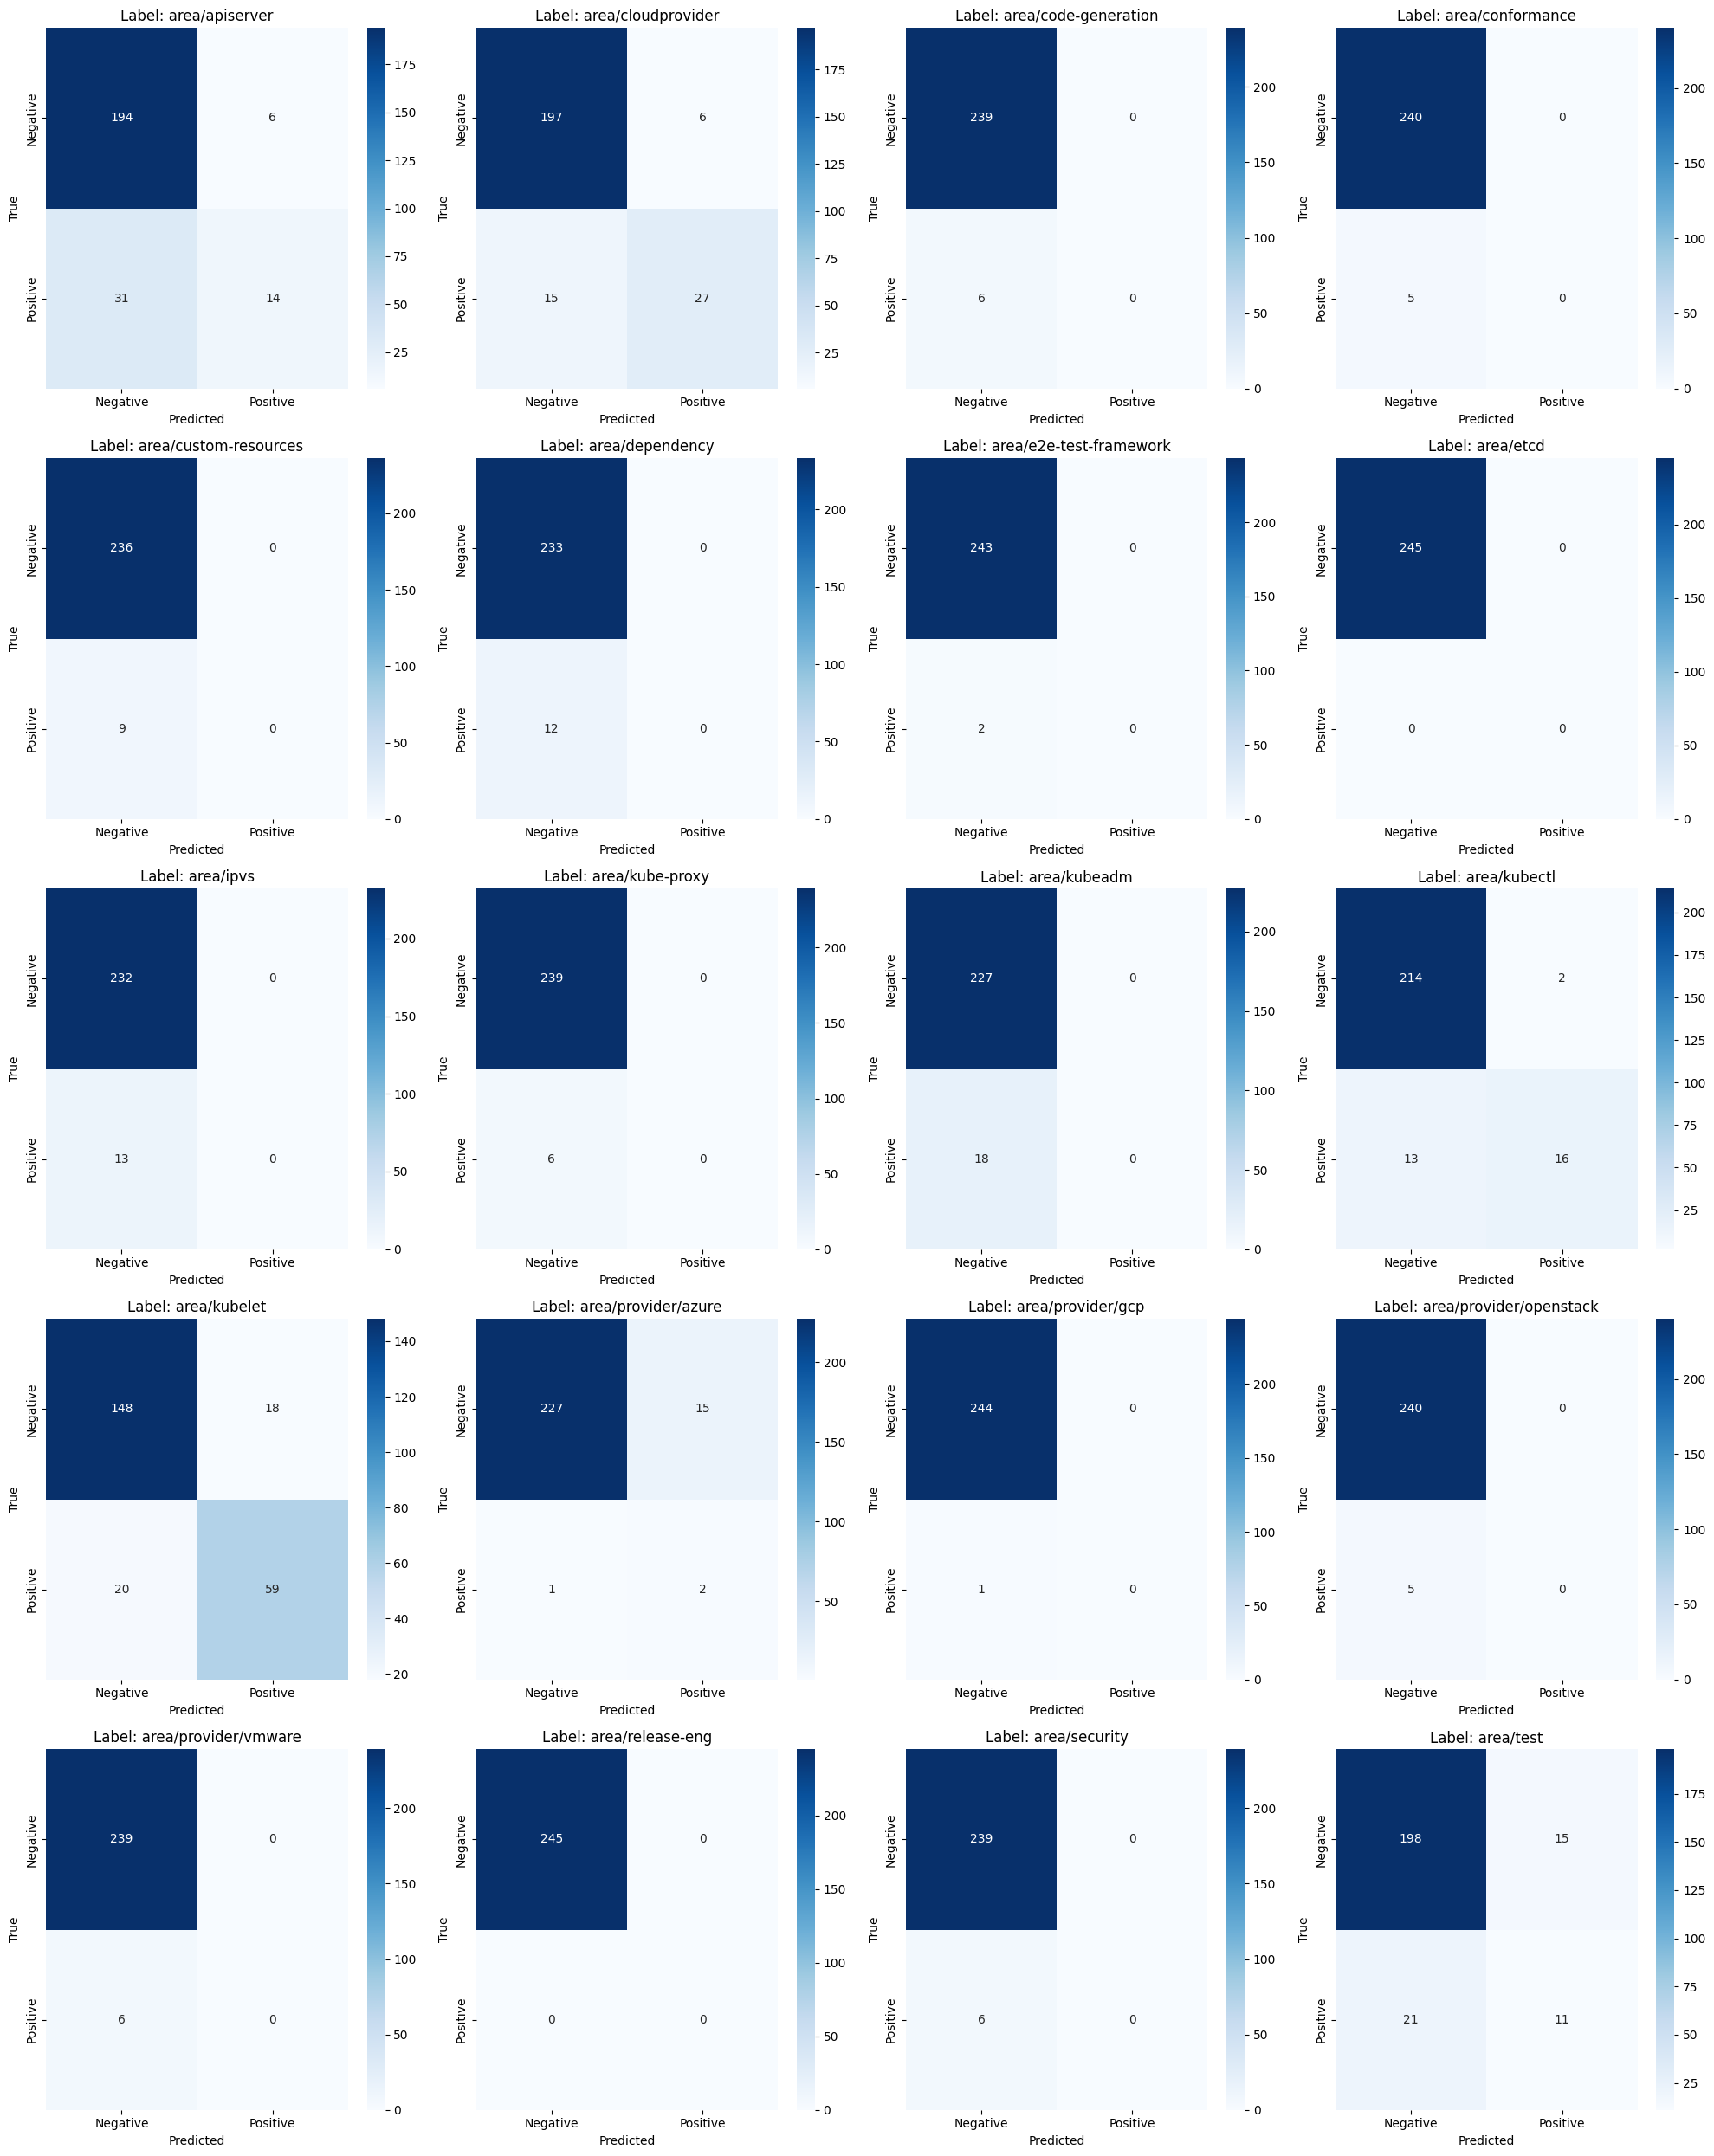

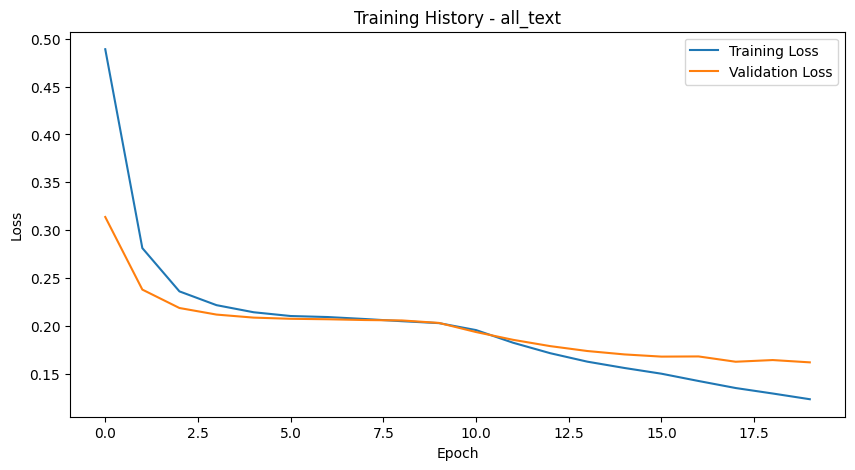

In [17]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# Removing Most Frequent Words

## Threshold 0.5

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count: 247
Label: 3, count: 43
Labe

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train Loss: 0.4910, Train Accuracy (Exact Match): 0.0133
Val Loss: 0.3139
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.2809, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2379
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Train Loss: 0.2356, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2182
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2209, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2110
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2128, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2070
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2064, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2032
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1985, Train Accuracy (Exact Match): 0.0020
Val Loss: 0.1987
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9357
Val Accuracy (Jaccard): 0.0054
Val Precision: 0.0082, Val Recall: 0.0054, Val F1: 0.0065
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.10s/it]


Train Loss: 0.1875, Train Accuracy (Exact Match): 0.0706
Val Loss: 0.1922
Val Accuracy (Exact Match): 0.2245
Val Accuracy (Hamming): 0.9441
Val Accuracy (Jaccard): 0.2430
Val Precision: 0.2694, Val Recall: 0.2430, Val F1: 0.2503
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1750, Train Accuracy (Exact Match): 0.2057
Val Loss: 0.1858
Val Accuracy (Exact Match): 0.2571
Val Accuracy (Hamming): 0.9461
Val Accuracy (Jaccard): 0.2944
Val Precision: 0.3337, Val Recall: 0.2995, Val F1: 0.3074
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1641, Train Accuracy (Exact Match): 0.2579
Val Loss: 0.1785
Val Accuracy (Exact Match): 0.2857
Val Accuracy (Hamming): 0.9490
Val Accuracy (Jaccard): 0.3437
Val Precision: 0.3888, Val Recall: 0.3641, Val F1: 0.3642
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1537, Train Accuracy (Exact Match): 0.3388
Val Loss: 0.1721
Val Accuracy (Exact Match): 0.3143
Val Accuracy (Hamming): 0.9502
Val Accuracy (Jaccard): 0.3733
Val Precision: 0.4208, Val Recall: 0.3920, Val F1: 0.3941
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1438, Train Accuracy (Exact Match): 0.4299
Val Loss: 0.1639
Val Accuracy (Exact Match): 0.3551
Val Accuracy (Hamming): 0.9531
Val Accuracy (Jaccard): 0.4272
Val Precision: 0.4867, Val Recall: 0.4452, Val F1: 0.4519
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1334, Train Accuracy (Exact Match): 0.4841
Val Loss: 0.1589
Val Accuracy (Exact Match): 0.3429
Val Accuracy (Hamming): 0.9506
Val Accuracy (Jaccard): 0.4282
Val Precision: 0.4908, Val Recall: 0.4625, Val F1: 0.4582
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1241, Train Accuracy (Exact Match): 0.5292
Val Loss: 0.1545
Val Accuracy (Exact Match): 0.3714
Val Accuracy (Hamming): 0.9512
Val Accuracy (Jaccard): 0.4581
Val Precision: 0.5235, Val Recall: 0.4938, Val F1: 0.4895
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1164, Train Accuracy (Exact Match): 0.5711
Val Loss: 0.1504
Val Accuracy (Exact Match): 0.4245
Val Accuracy (Hamming): 0.9541
Val Accuracy (Jaccard): 0.5078
Val Precision: 0.5765, Val Recall: 0.5367, Val F1: 0.5378
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1096, Train Accuracy (Exact Match): 0.5906
Val Loss: 0.1497
Val Accuracy (Exact Match): 0.3878
Val Accuracy (Hamming): 0.9516
Val Accuracy (Jaccard): 0.4773
Val Precision: 0.5439, Val Recall: 0.5127, Val F1: 0.5095

Epoch 17/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1036, Train Accuracy (Exact Match): 0.6100
Val Loss: 0.1489
Val Accuracy (Exact Match): 0.3959
Val Accuracy (Hamming): 0.9516
Val Accuracy (Jaccard): 0.4821
Val Precision: 0.5480, Val Recall: 0.5161, Val F1: 0.5136

Epoch 18/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.0971, Train Accuracy (Exact Match): 0.6182
Val Loss: 0.1448
Val Accuracy (Exact Match): 0.4408
Val Accuracy (Hamming): 0.9541
Val Accuracy (Jaccard): 0.5318
Val Precision: 0.5984, Val Recall: 0.5712, Val F1: 0.5655
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.0918, Train Accuracy (Exact Match): 0.6295
Val Loss: 0.1443
Val Accuracy (Exact Match): 0.4041
Val Accuracy (Hamming): 0.9533
Val Accuracy (Jaccard): 0.4961
Val Precision: 0.5643, Val Recall: 0.5345, Val F1: 0.5296

Epoch 20/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.0871, Train Accuracy (Exact Match): 0.6592
Val Loss: 0.1429
Val Accuracy (Exact Match): 0.4776
Val Accuracy (Hamming): 0.9571
Val Accuracy (Jaccard): 0.5805
Val Precision: 0.6473, Val Recall: 0.6318, Val F1: 0.6188
Saved new best model to ./results/run_20250310_112619_all_text_0.5/best_model_all_text_0.5.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4776
Hamming Accuracy: 0.9571
Jaccard Similarity: 0.5805
Precision: 0.6473
Recall: 0.6318
F1 Score: 0.6188

Training completed! Results saved to ./results/run_20250310_112619_all_text_0.5


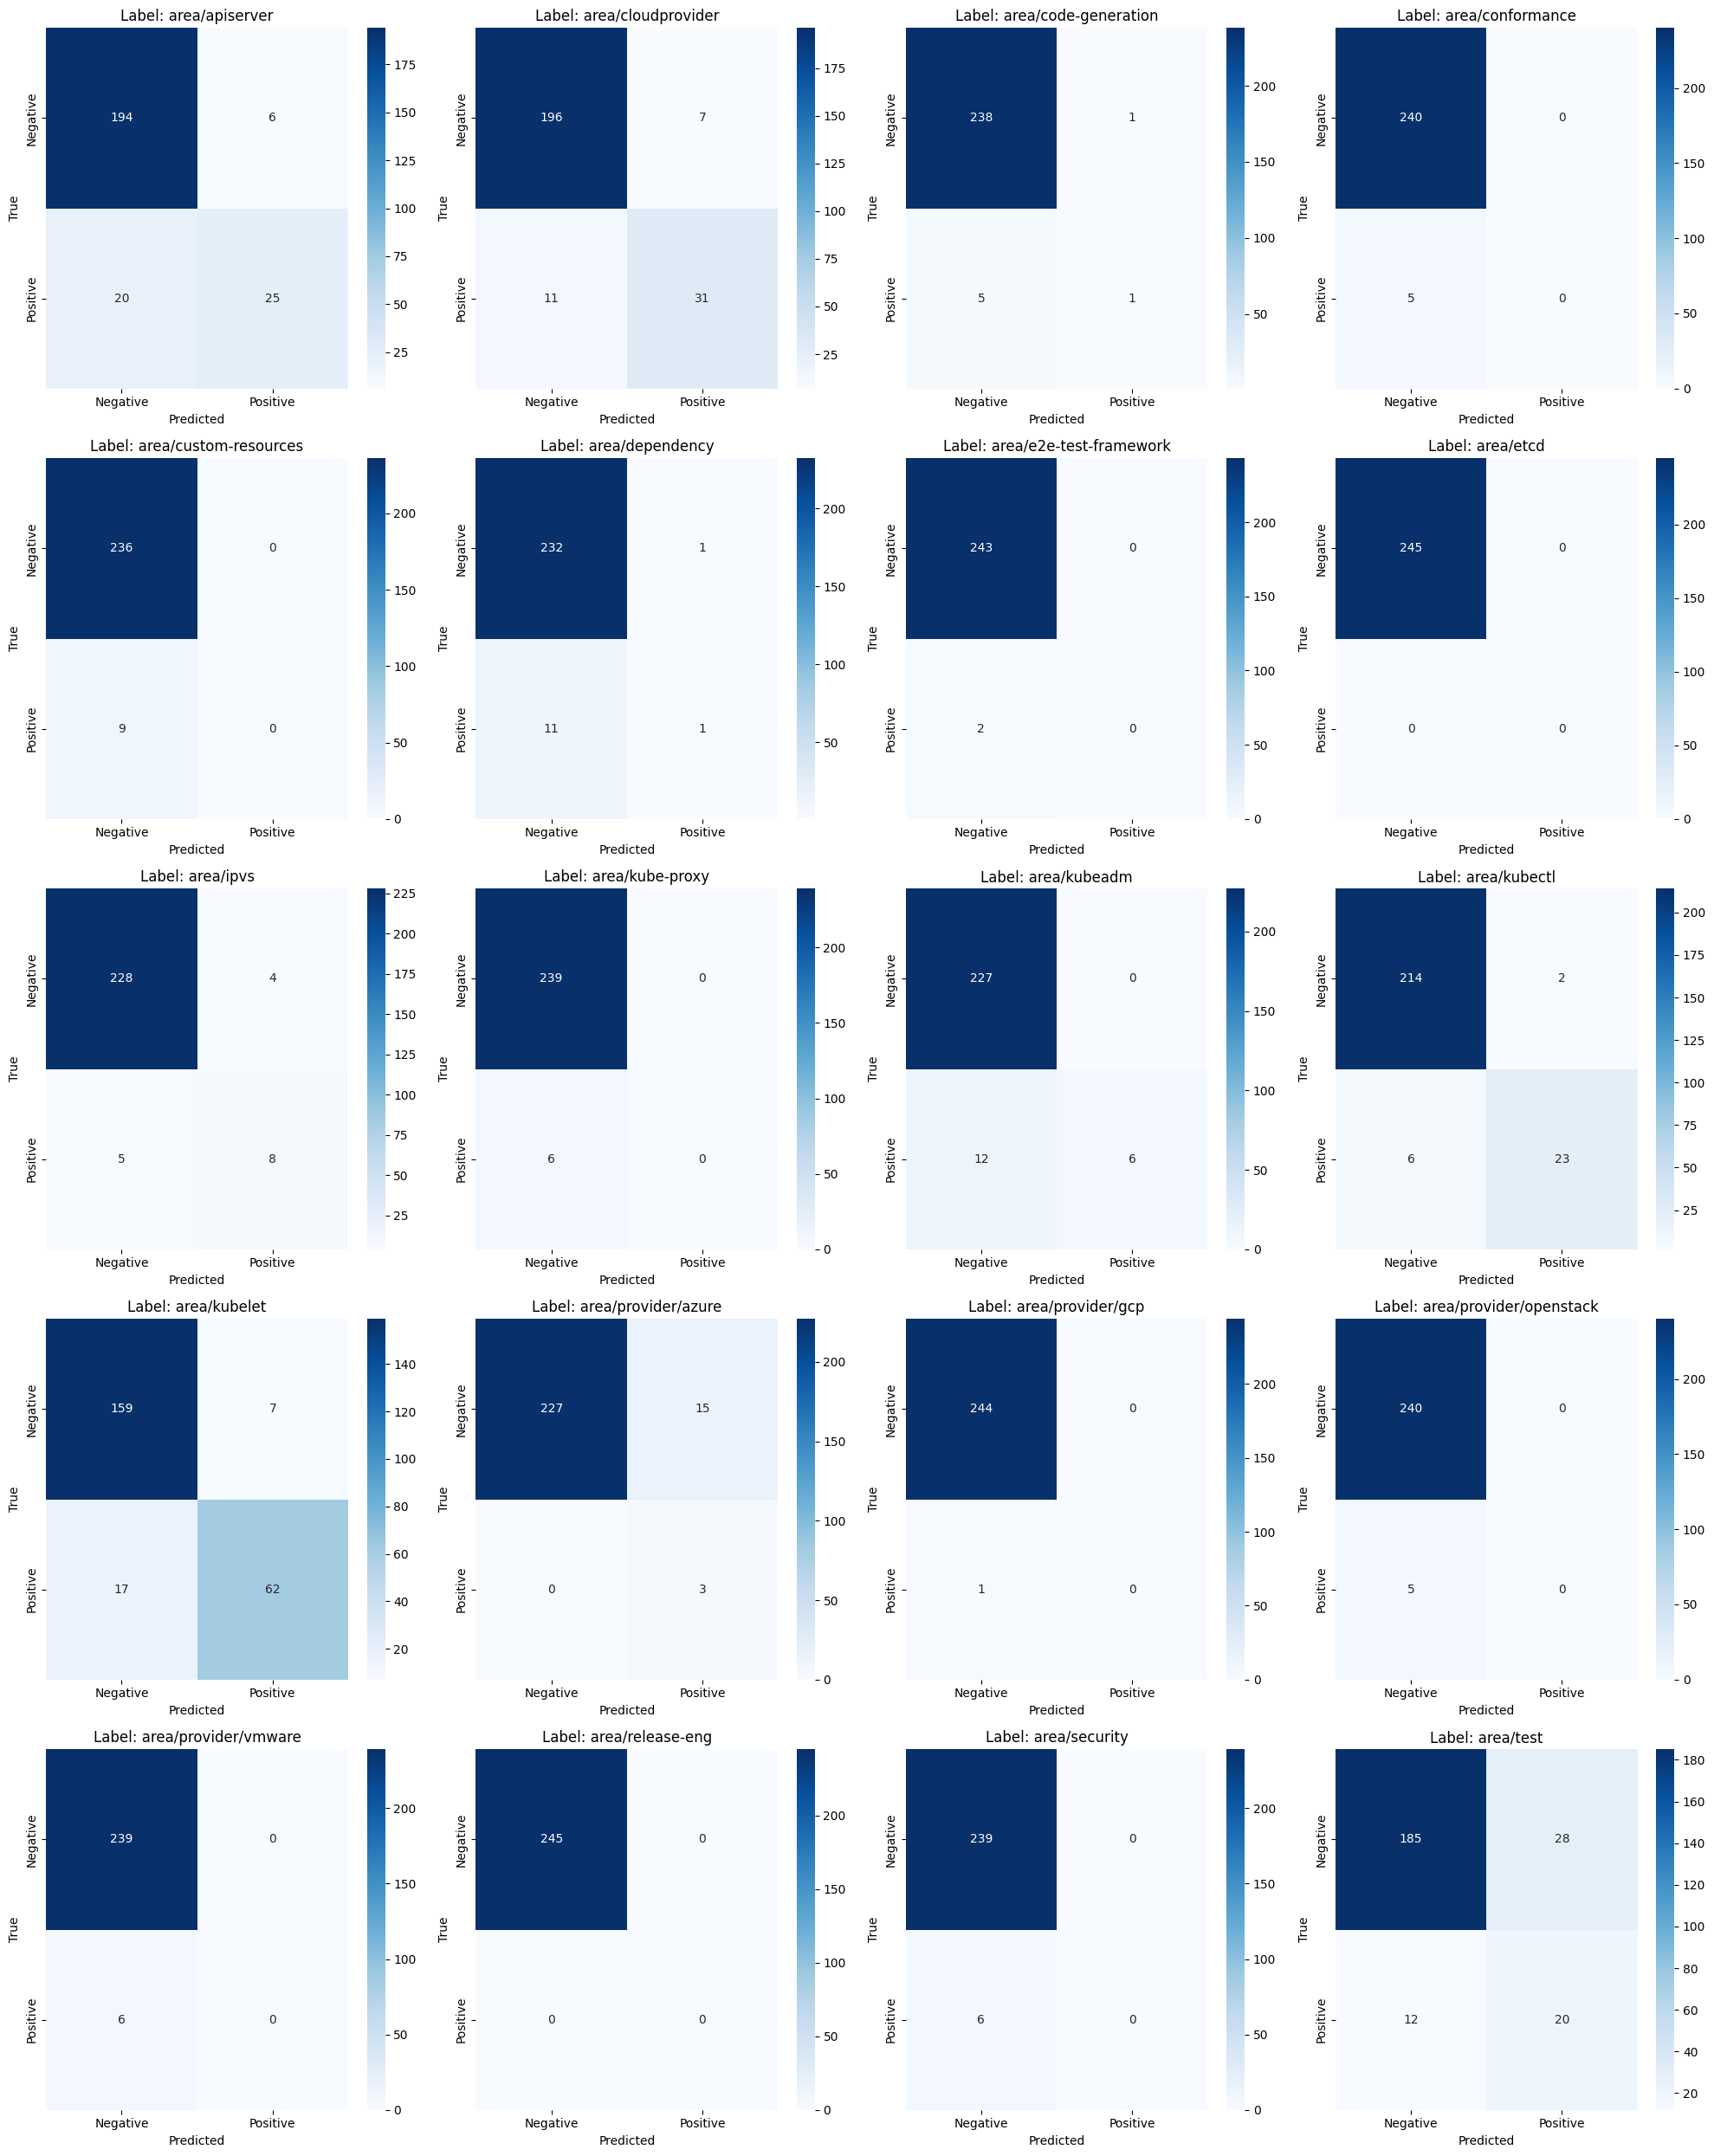

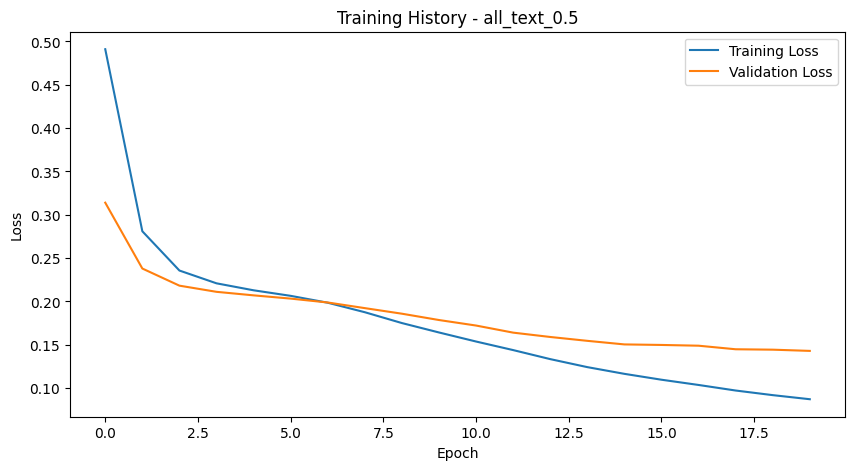

In [11]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.6

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count: 247
Label: 3, count: 43
Labe

Training: 100%|██████████| 31/31 [00:35<00:00,  1.16s/it]


Train Loss: 0.4909, Train Accuracy (Exact Match): 0.0133
Val Loss: 0.3140
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.10s/it]


Train Loss: 0.2809, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2381
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2357, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2182
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2209, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2111
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2129, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2071
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.2067, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2034
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1994, Train Accuracy (Exact Match): 0.0010
Val Loss: 0.1993
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9357
Val Accuracy (Jaccard): 0.0054
Val Precision: 0.0082, Val Recall: 0.0054, Val F1: 0.0065
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1889, Train Accuracy (Exact Match): 0.0512
Val Loss: 0.1932
Val Accuracy (Exact Match): 0.2082
Val Accuracy (Hamming): 0.9437
Val Accuracy (Jaccard): 0.2260
Val Precision: 0.2531, Val Recall: 0.2260, Val F1: 0.2333
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1767, Train Accuracy (Exact Match): 0.1986
Val Loss: 0.1861
Val Accuracy (Exact Match): 0.2571
Val Accuracy (Hamming): 0.9461
Val Accuracy (Jaccard): 0.2910
Val Precision: 0.3276, Val Recall: 0.2940, Val F1: 0.3027
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1659, Train Accuracy (Exact Match): 0.2497
Val Loss: 0.1794
Val Accuracy (Exact Match): 0.2571
Val Accuracy (Hamming): 0.9478
Val Accuracy (Jaccard): 0.3066
Val Precision: 0.3500, Val Recall: 0.3199, Val F1: 0.3238
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1558, Train Accuracy (Exact Match): 0.3081
Val Loss: 0.1730
Val Accuracy (Exact Match): 0.2857
Val Accuracy (Hamming): 0.9494
Val Accuracy (Jaccard): 0.3454
Val Precision: 0.3929, Val Recall: 0.3648, Val F1: 0.3659
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1458, Train Accuracy (Exact Match): 0.4084
Val Loss: 0.1658
Val Accuracy (Exact Match): 0.3265
Val Accuracy (Hamming): 0.9506
Val Accuracy (Jaccard): 0.3997
Val Precision: 0.4622, Val Recall: 0.4201, Val F1: 0.4258
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1361, Train Accuracy (Exact Match): 0.4749
Val Loss: 0.1600
Val Accuracy (Exact Match): 0.3306
Val Accuracy (Hamming): 0.9514
Val Accuracy (Jaccard): 0.4166
Val Precision: 0.4867, Val Recall: 0.4469, Val F1: 0.4473
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1266, Train Accuracy (Exact Match): 0.5148
Val Loss: 0.1555
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Hamming): 0.9506
Val Accuracy (Jaccard): 0.4316
Val Precision: 0.4969, Val Recall: 0.4652, Val F1: 0.4623
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1187, Train Accuracy (Exact Match): 0.5568
Val Loss: 0.1510
Val Accuracy (Exact Match): 0.3959
Val Accuracy (Hamming): 0.9522
Val Accuracy (Jaccard): 0.4761
Val Precision: 0.5439, Val Recall: 0.5047, Val F1: 0.5061
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1117, Train Accuracy (Exact Match): 0.5773
Val Loss: 0.1496
Val Accuracy (Exact Match): 0.3878
Val Accuracy (Hamming): 0.9510
Val Accuracy (Jaccard): 0.4746
Val Precision: 0.5378, Val Recall: 0.5120, Val F1: 0.5068
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1052, Train Accuracy (Exact Match): 0.5926
Val Loss: 0.1487
Val Accuracy (Exact Match): 0.3837
Val Accuracy (Hamming): 0.9508
Val Accuracy (Jaccard): 0.4694
Val Precision: 0.5337, Val Recall: 0.5044, Val F1: 0.5010

Epoch 18/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0992, Train Accuracy (Exact Match): 0.6141
Val Loss: 0.1448
Val Accuracy (Exact Match): 0.4327
Val Accuracy (Hamming): 0.9533
Val Accuracy (Jaccard): 0.5176
Val Precision: 0.5820, Val Recall: 0.5529, Val F1: 0.5492
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0941, Train Accuracy (Exact Match): 0.6213
Val Loss: 0.1438
Val Accuracy (Exact Match): 0.4367
Val Accuracy (Hamming): 0.9551
Val Accuracy (Jaccard): 0.5354
Val Precision: 0.6051, Val Recall: 0.5765, Val F1: 0.5704
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0901, Train Accuracy (Exact Match): 0.6387
Val Loss: 0.1424
Val Accuracy (Exact Match): 0.4735
Val Accuracy (Hamming): 0.9557
Val Accuracy (Jaccard): 0.5735
Val Precision: 0.6412, Val Recall: 0.6210, Val F1: 0.6103
Saved new best model to ./results/run_20250310_114013_all_text_0.6/best_model_all_text_0.6.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4735
Hamming Accuracy: 0.9557
Jaccard Similarity: 0.5735
Precision: 0.6412
Recall: 0.6210
F1 Score: 0.6103

Training completed! Results saved to ./results/run_20250310_114013_all_text_0.6


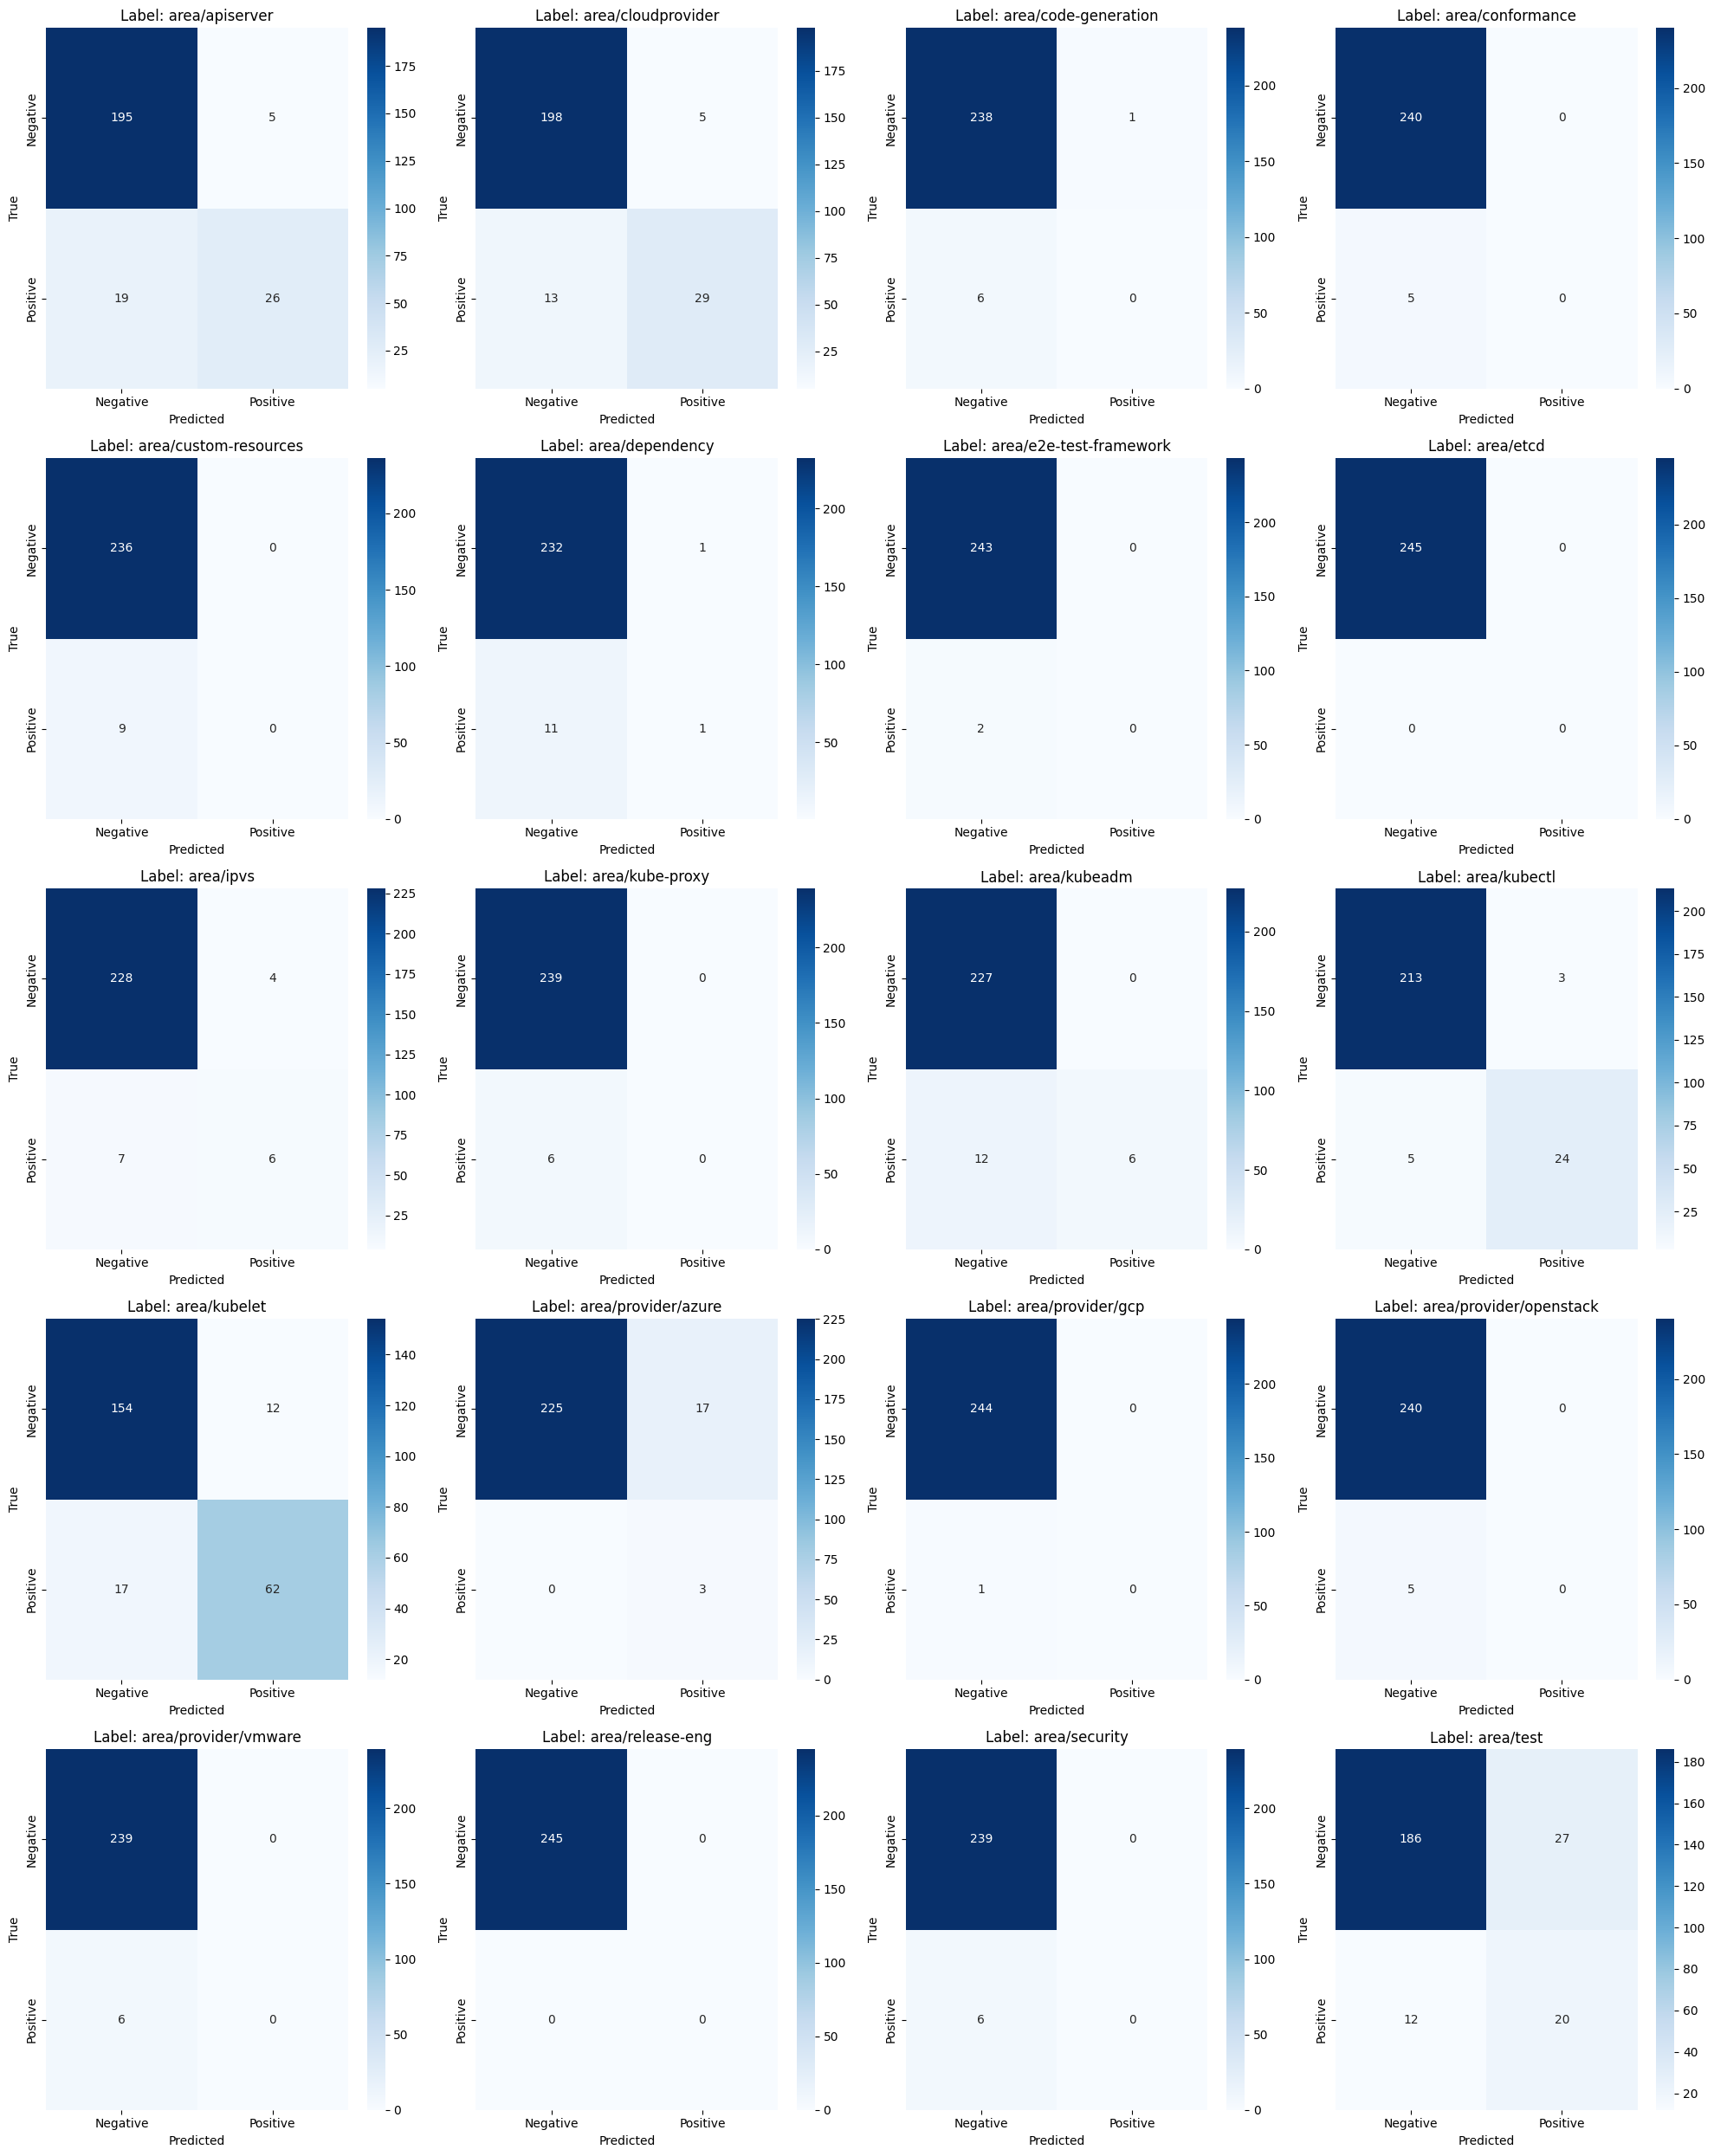

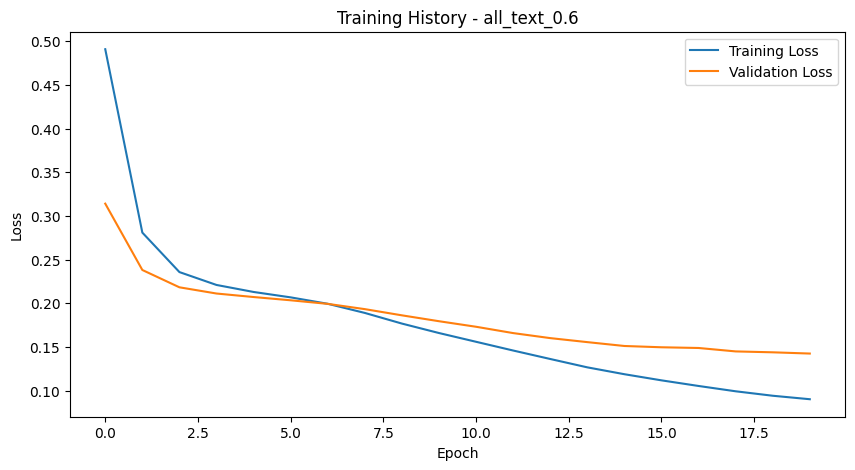

In [12]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.6',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.7

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count: 247
Label: 3, count: 43
Labe

Training: 100%|██████████| 31/31 [00:36<00:00,  1.16s/it]


Train Loss: 0.4909, Train Accuracy (Exact Match): 0.0102
Val Loss: 0.3141
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2810, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2381
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2357, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2183
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2211, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2112
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2131, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2073
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2077, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2040
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2014, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1997
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9353
Val Accuracy (Jaccard): 0.0027
Val Precision: 0.0082, Val Recall: 0.0027, Val F1: 0.0041
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.14s/it]


Train Loss: 0.1910, Train Accuracy (Exact Match): 0.0379
Val Loss: 0.1932
Val Accuracy (Exact Match): 0.2122
Val Accuracy (Hamming): 0.9441
Val Accuracy (Jaccard): 0.2273
Val Precision: 0.2490, Val Recall: 0.2273, Val F1: 0.2333
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1782, Train Accuracy (Exact Match): 0.1832
Val Loss: 0.1858
Val Accuracy (Exact Match): 0.2531
Val Accuracy (Hamming): 0.9455
Val Accuracy (Jaccard): 0.2896
Val Precision: 0.3235, Val Recall: 0.2967, Val F1: 0.3020
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1665, Train Accuracy (Exact Match): 0.2579
Val Loss: 0.1775
Val Accuracy (Exact Match): 0.2571
Val Accuracy (Hamming): 0.9473
Val Accuracy (Jaccard): 0.3066
Val Precision: 0.3500, Val Recall: 0.3199, Val F1: 0.3238
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1549, Train Accuracy (Exact Match): 0.3296
Val Loss: 0.1696
Val Accuracy (Exact Match): 0.3061
Val Accuracy (Hamming): 0.9504
Val Accuracy (Jaccard): 0.3693
Val Precision: 0.4208, Val Recall: 0.3893, Val F1: 0.3914
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1444, Train Accuracy (Exact Match): 0.4330
Val Loss: 0.1610
Val Accuracy (Exact Match): 0.3959
Val Accuracy (Hamming): 0.9553
Val Accuracy (Jaccard): 0.4690
Val Precision: 0.5297, Val Recall: 0.4911, Val F1: 0.4950
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1345, Train Accuracy (Exact Match): 0.4985
Val Loss: 0.1555
Val Accuracy (Exact Match): 0.3837
Val Accuracy (Hamming): 0.9535
Val Accuracy (Jaccard): 0.4663
Val Precision: 0.5316, Val Recall: 0.4948, Val F1: 0.4956
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1251, Train Accuracy (Exact Match): 0.5425
Val Loss: 0.1534
Val Accuracy (Exact Match): 0.4122
Val Accuracy (Hamming): 0.9543
Val Accuracy (Jaccard): 0.5054
Val Precision: 0.5684, Val Recall: 0.5462, Val F1: 0.5386
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1181, Train Accuracy (Exact Match): 0.5537
Val Loss: 0.1499
Val Accuracy (Exact Match): 0.4163
Val Accuracy (Hamming): 0.9531
Val Accuracy (Jaccard): 0.5016
Val Precision: 0.5724, Val Recall: 0.5319, Val F1: 0.5330

Epoch 16/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1111, Train Accuracy (Exact Match): 0.5885
Val Loss: 0.1489
Val Accuracy (Exact Match): 0.4082
Val Accuracy (Hamming): 0.9527
Val Accuracy (Jaccard): 0.5006
Val Precision: 0.5704, Val Recall: 0.5394, Val F1: 0.5347

Epoch 17/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1047, Train Accuracy (Exact Match): 0.6039
Val Loss: 0.1496
Val Accuracy (Exact Match): 0.3959
Val Accuracy (Hamming): 0.9514
Val Accuracy (Jaccard): 0.4869
Val Precision: 0.5520, Val Recall: 0.5263, Val F1: 0.5197

Epoch 18/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0990, Train Accuracy (Exact Match): 0.6213
Val Loss: 0.1452
Val Accuracy (Exact Match): 0.4204
Val Accuracy (Hamming): 0.9535
Val Accuracy (Jaccard): 0.5190
Val Precision: 0.5867, Val Recall: 0.5659, Val F1: 0.5557
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0942, Train Accuracy (Exact Match): 0.6387
Val Loss: 0.1458
Val Accuracy (Exact Match): 0.4327
Val Accuracy (Hamming): 0.9541
Val Accuracy (Jaccard): 0.5182
Val Precision: 0.5806, Val Recall: 0.5535, Val F1: 0.5489

Epoch 20/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0894, Train Accuracy (Exact Match): 0.6356
Val Loss: 0.1432
Val Accuracy (Exact Match): 0.4694
Val Accuracy (Hamming): 0.9551
Val Accuracy (Jaccard): 0.5769
Val Precision: 0.6473, Val Recall: 0.6312, Val F1: 0.6165
Saved new best model to ./results/run_20250310_115424_all_text_0.7/best_model_all_text_0.7.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4694
Hamming Accuracy: 0.9551
Jaccard Similarity: 0.5769
Precision: 0.6473
Recall: 0.6312
F1 Score: 0.6165

Training completed! Results saved to ./results/run_20250310_115424_all_text_0.7


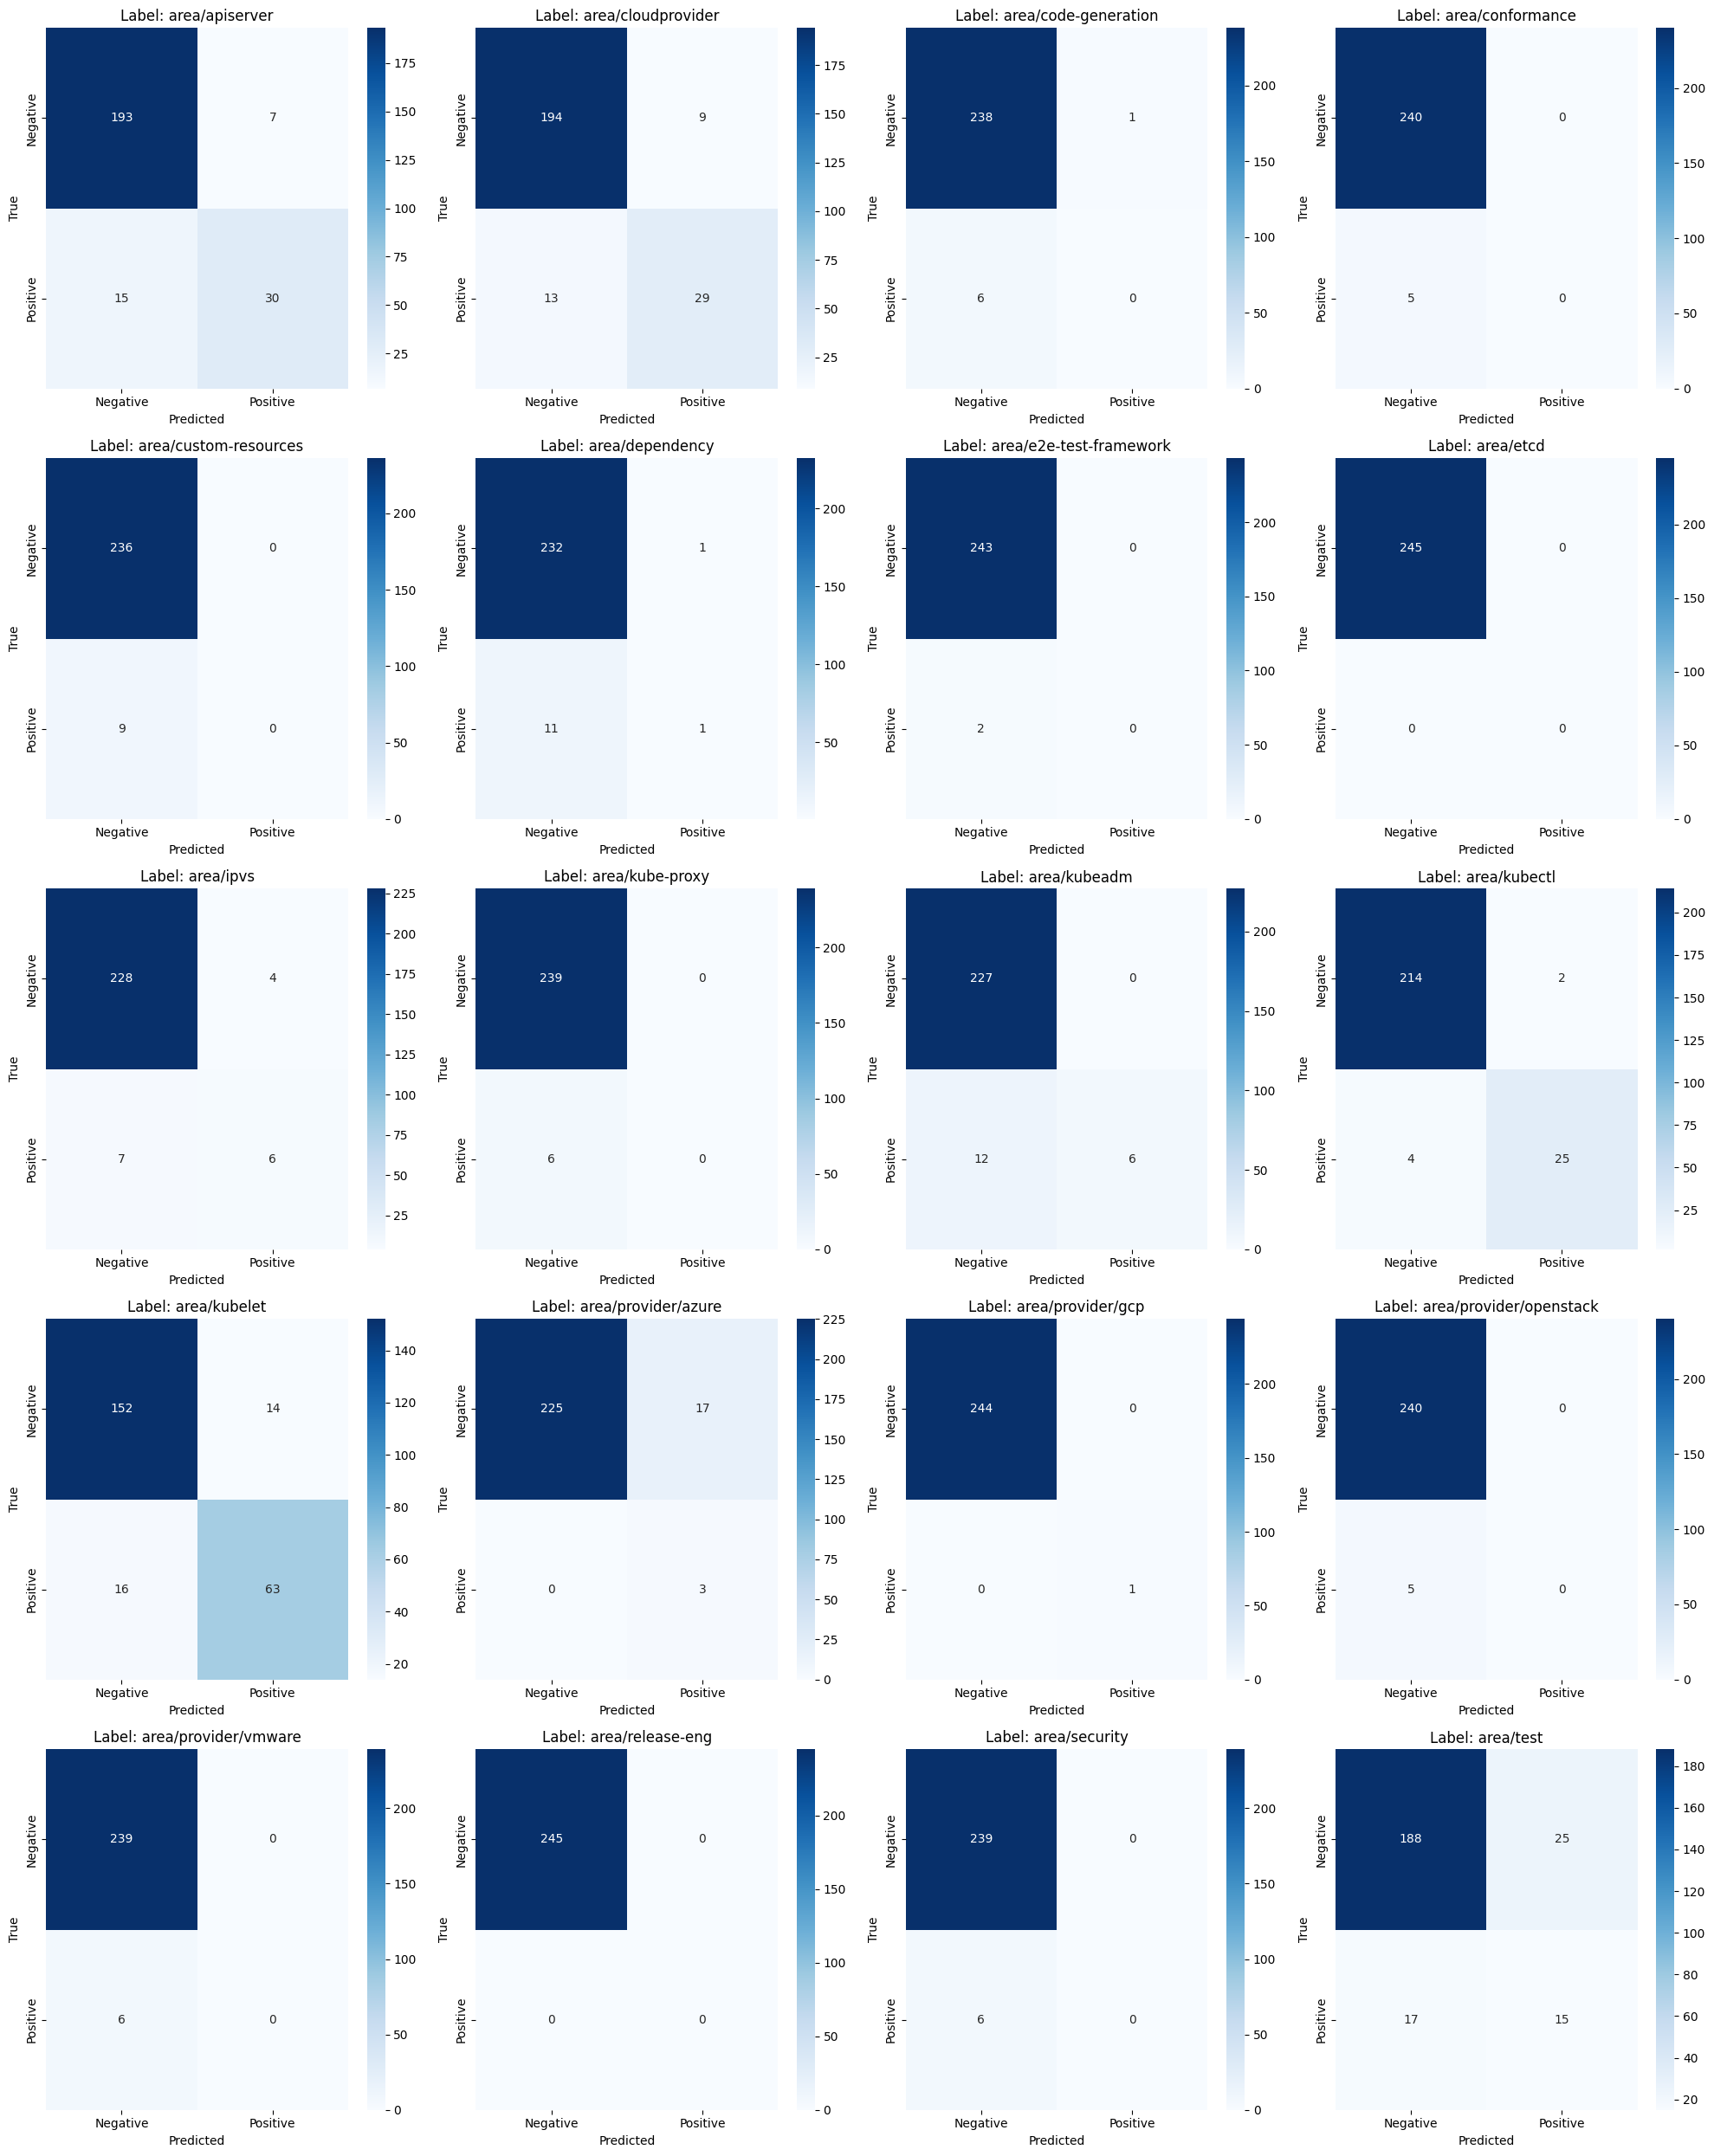

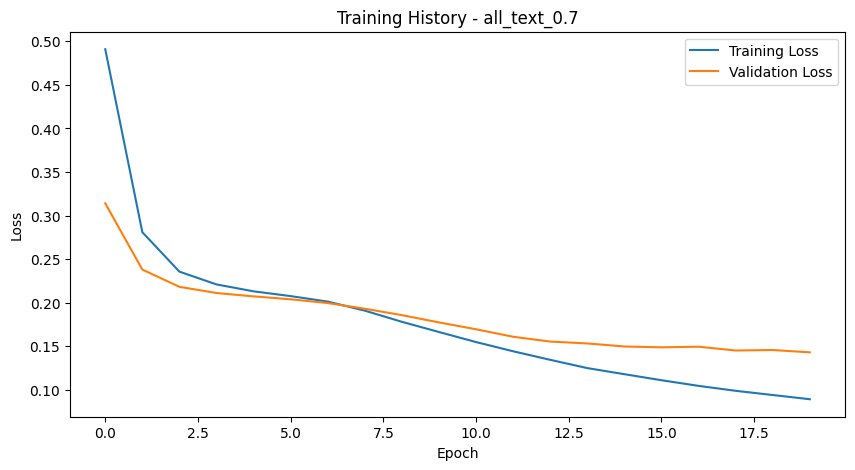

In [13]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.7',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.8

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count: 247
Label: 3, count: 43
Labe

Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2211, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2112
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2132, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2074
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2081, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2042
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2019, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1995
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9353
Val Accuracy (Jaccard): 0.0027
Val Precision: 0.0082, Val Recall: 0.0027, Val F1: 0.0041
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1911, Train Accuracy (Exact Match): 0.0338
Val Loss: 0.1906
Val Accuracy (Exact Match): 0.2245
Val Accuracy (Hamming): 0.9447
Val Accuracy (Jaccard): 0.2403
Val Precision: 0.2612, Val Recall: 0.2403, Val F1: 0.2463
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1771, Train Accuracy (Exact Match): 0.1996
Val Loss: 0.1811
Val Accuracy (Exact Match): 0.2571
Val Accuracy (Hamming): 0.9463
Val Accuracy (Jaccard): 0.2913
Val Precision: 0.3313, Val Recall: 0.2940, Val F1: 0.3039
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1656, Train Accuracy (Exact Match): 0.2702
Val Loss: 0.1736
Val Accuracy (Exact Match): 0.2857
Val Accuracy (Hamming): 0.9500
Val Accuracy (Jaccard): 0.3406
Val Precision: 0.3929, Val Recall: 0.3518, Val F1: 0.3598
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1550, Train Accuracy (Exact Match): 0.3367
Val Loss: 0.1675
Val Accuracy (Exact Match): 0.3306
Val Accuracy (Hamming): 0.9504
Val Accuracy (Jaccard): 0.3958
Val Precision: 0.4453, Val Recall: 0.4199, Val F1: 0.4193
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1444, Train Accuracy (Exact Match): 0.4309
Val Loss: 0.1591
Val Accuracy (Exact Match): 0.3878
Val Accuracy (Hamming): 0.9559
Val Accuracy (Jaccard): 0.4687
Val Precision: 0.5255, Val Recall: 0.4956, Val F1: 0.4960
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1351, Train Accuracy (Exact Match): 0.4913
Val Loss: 0.1543
Val Accuracy (Exact Match): 0.4041
Val Accuracy (Hamming): 0.9545
Val Accuracy (Jaccard): 0.4797
Val Precision: 0.5418, Val Recall: 0.5025, Val F1: 0.5064
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1258, Train Accuracy (Exact Match): 0.5251
Val Loss: 0.1514
Val Accuracy (Exact Match): 0.4245
Val Accuracy (Hamming): 0.9551
Val Accuracy (Jaccard): 0.5152
Val Precision: 0.5827, Val Recall: 0.5503, Val F1: 0.5479
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1184, Train Accuracy (Exact Match): 0.5691
Val Loss: 0.1463
Val Accuracy (Exact Match): 0.4408
Val Accuracy (Hamming): 0.9557
Val Accuracy (Jaccard): 0.5254
Val Precision: 0.5949, Val Recall: 0.5523, Val F1: 0.5553
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1107, Train Accuracy (Exact Match): 0.5814
Val Loss: 0.1461
Val Accuracy (Exact Match): 0.4490
Val Accuracy (Hamming): 0.9555
Val Accuracy (Jaccard): 0.5345
Val Precision: 0.6031, Val Recall: 0.5651, Val F1: 0.5659
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1052, Train Accuracy (Exact Match): 0.6018
Val Loss: 0.1478
Val Accuracy (Exact Match): 0.4122
Val Accuracy (Hamming): 0.9524
Val Accuracy (Jaccard): 0.4978
Val Precision: 0.5622, Val Recall: 0.5297, Val F1: 0.5284

Epoch 18/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0996, Train Accuracy (Exact Match): 0.6172
Val Loss: 0.1401
Val Accuracy (Exact Match): 0.4857
Val Accuracy (Hamming): 0.9586
Val Accuracy (Jaccard): 0.5768
Val Precision: 0.6439, Val Recall: 0.6142, Val F1: 0.6100
Saved new best model to ./results/run_20250310_120836_all_text_0.8/best_model_all_text_0.8.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.0934, Train Accuracy (Exact Match): 0.6366
Val Loss: 0.1416
Val Accuracy (Exact Match): 0.4490
Val Accuracy (Hamming): 0.9557
Val Accuracy (Jaccard): 0.5362
Val Precision: 0.6051, Val Recall: 0.5692, Val F1: 0.5677

Epoch 20/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.0890, Train Accuracy (Exact Match): 0.6561
Val Loss: 0.1401
Val Accuracy (Exact Match): 0.4612
Val Accuracy (Hamming): 0.9571
Val Accuracy (Jaccard): 0.5693
Val Precision: 0.6412, Val Recall: 0.6203, Val F1: 0.6087

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4857
Hamming Accuracy: 0.9586
Jaccard Similarity: 0.5768
Precision: 0.6439
Recall: 0.6142
F1 Score: 0.6100

Training completed! Results saved to ./results/run_20250310_120836_all_text_0.8


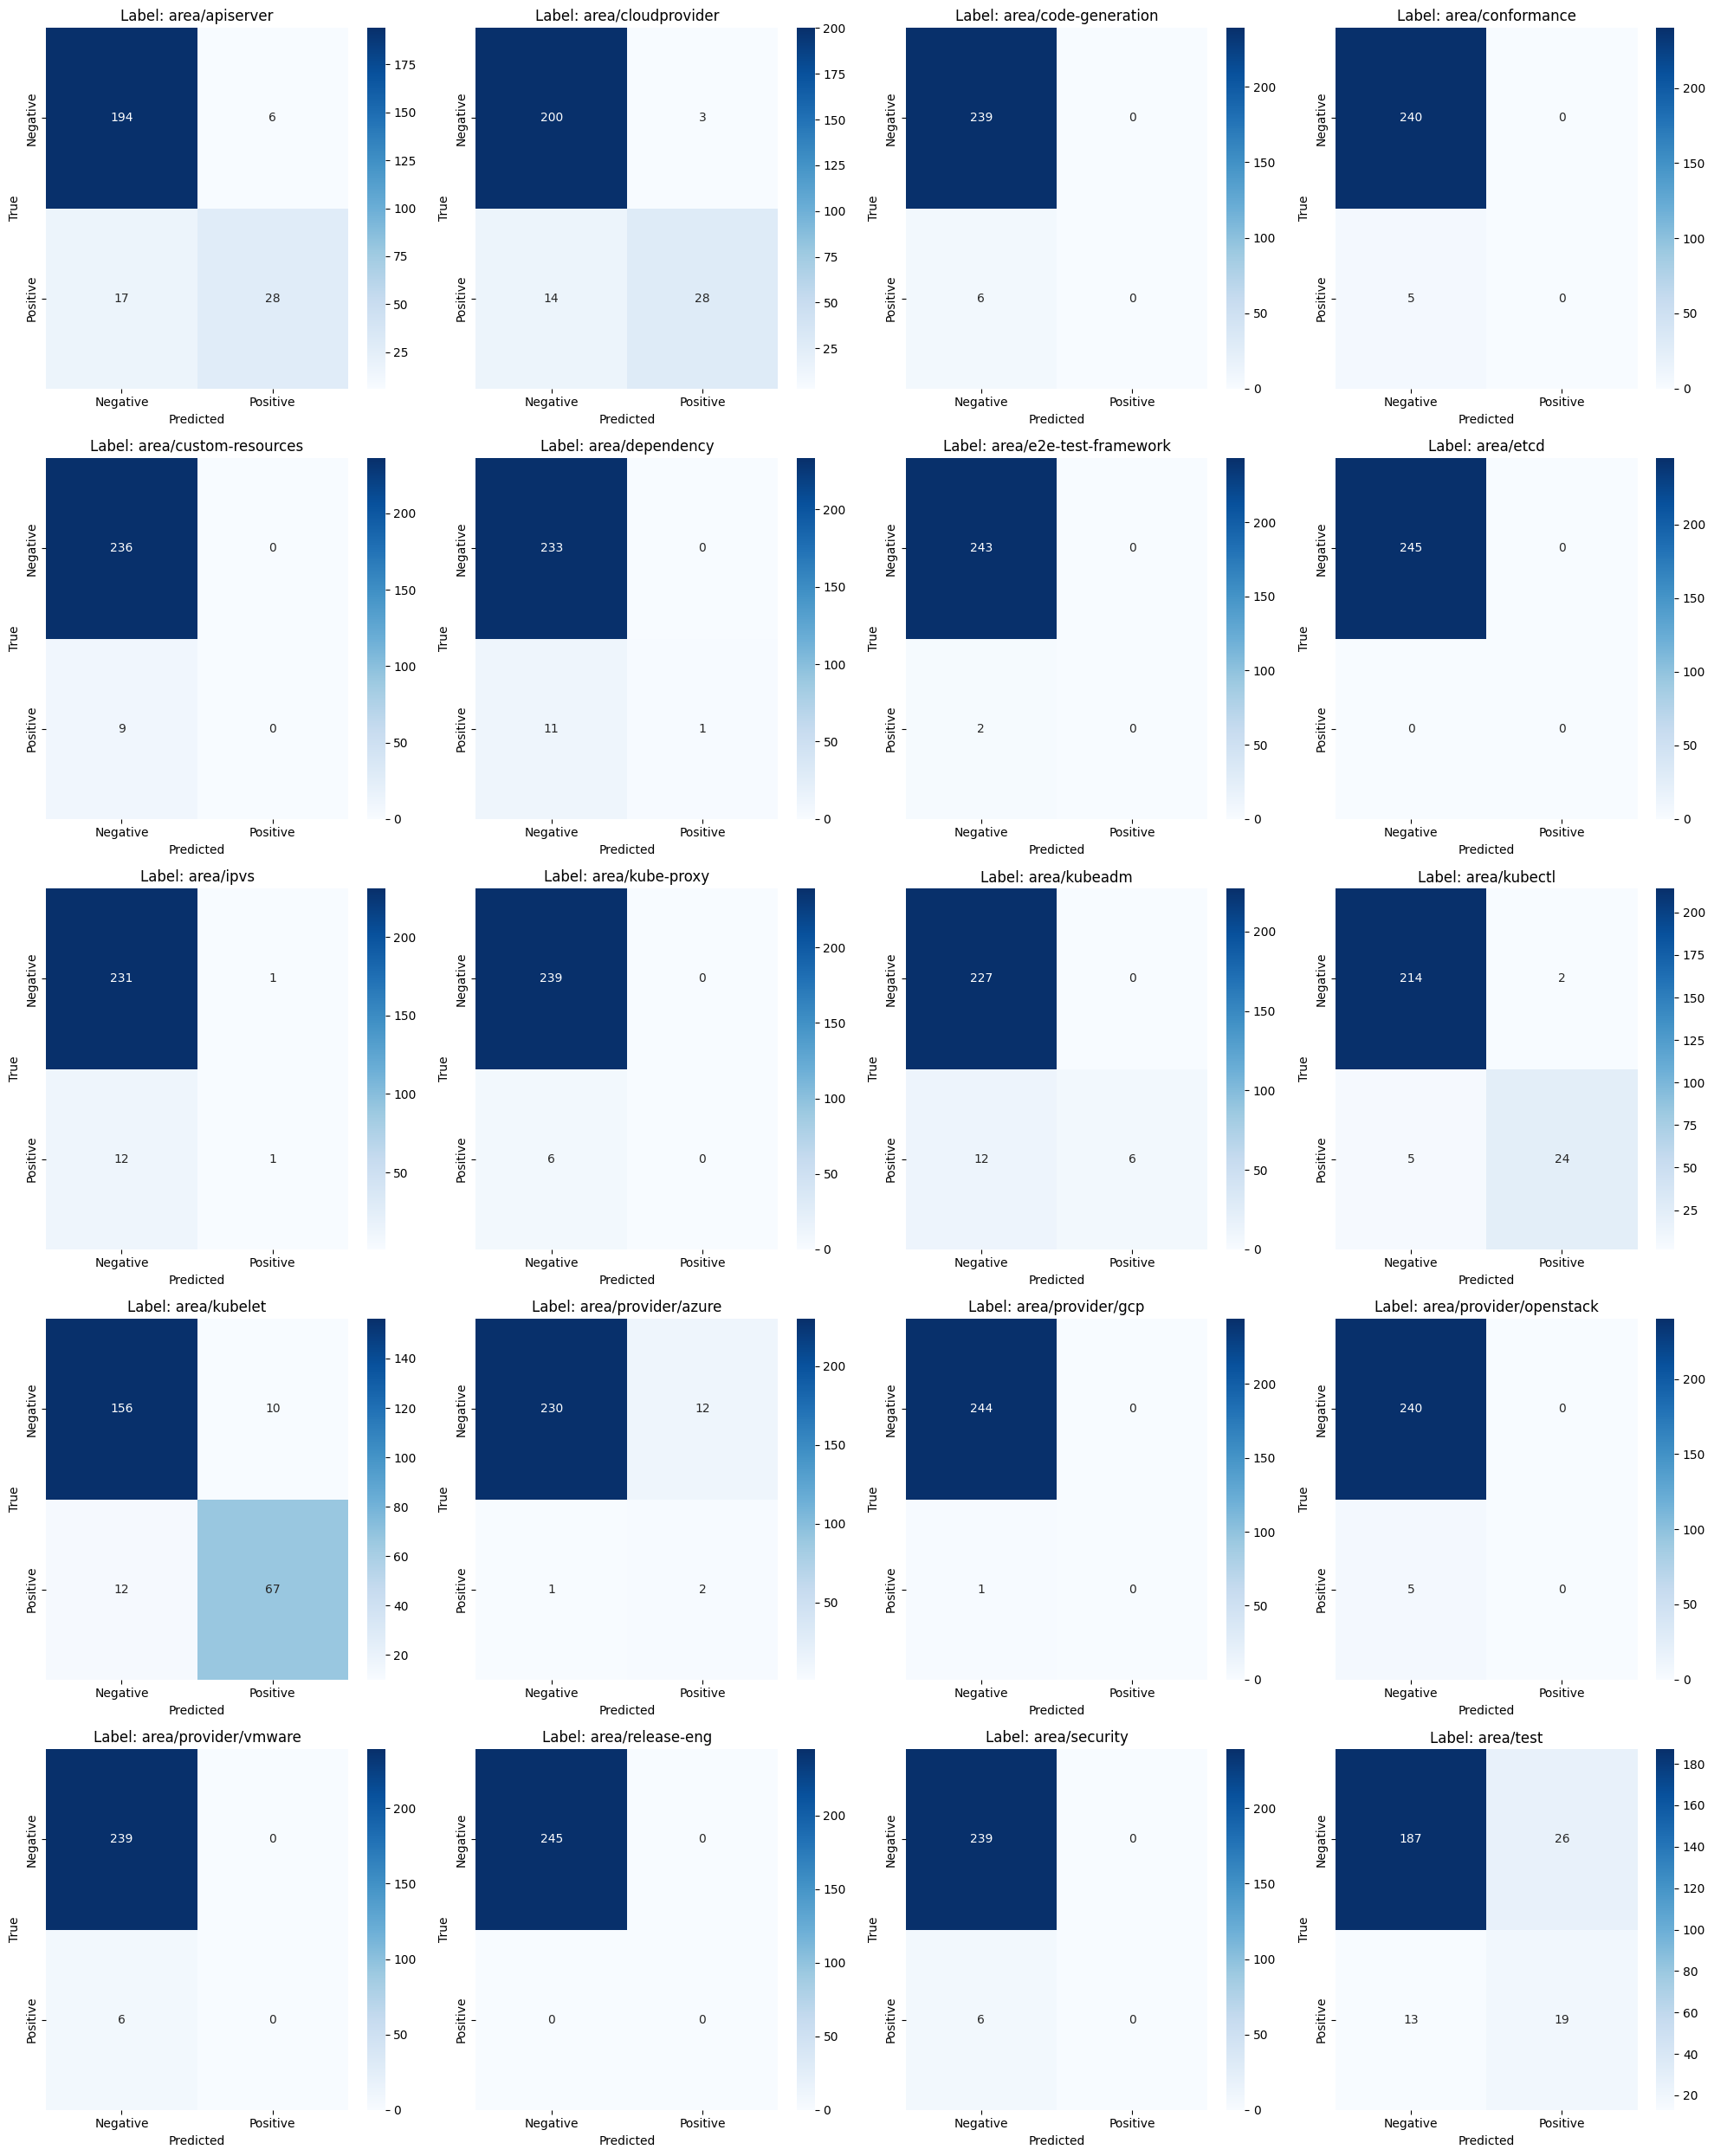

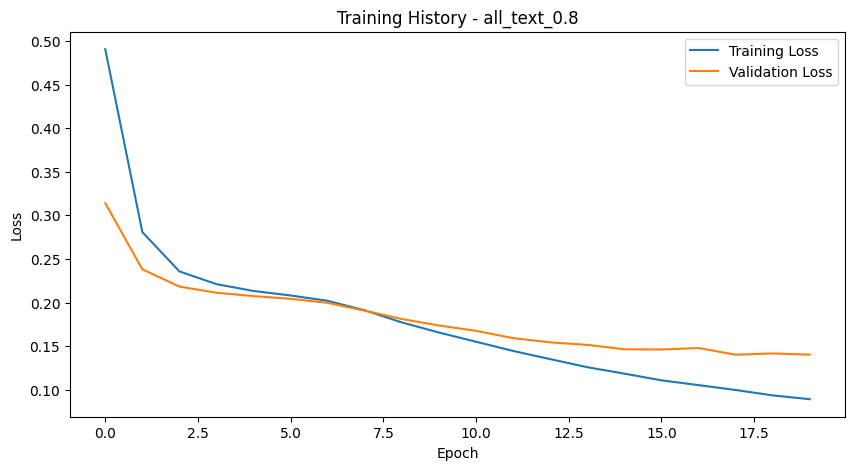

In [14]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.8',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.9

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count: 247
Label: 3, count: 43
Labe

Training: 100%|██████████| 31/31 [00:36<00:00,  1.17s/it]


Train Loss: 0.4909, Train Accuracy (Exact Match): 0.0113
Val Loss: 0.3142
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2809, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2381
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.2358, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2183
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2212, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2113
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2133, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2075
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.2082, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2045
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.2026, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1999
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9353
Val Accuracy (Jaccard): 0.0027
Val Precision: 0.0082, Val Recall: 0.0027, Val F1: 0.0041
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1919, Train Accuracy (Exact Match): 0.0307
Val Loss: 0.1909
Val Accuracy (Exact Match): 0.2082
Val Accuracy (Hamming): 0.9435
Val Accuracy (Jaccard): 0.2185
Val Precision: 0.2327, Val Recall: 0.2185, Val F1: 0.2224
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1780, Train Accuracy (Exact Match): 0.1965
Val Loss: 0.1814
Val Accuracy (Exact Match): 0.2653
Val Accuracy (Hamming): 0.9467
Val Accuracy (Jaccard): 0.2974
Val Precision: 0.3374, Val Recall: 0.2981, Val F1: 0.3094
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1663, Train Accuracy (Exact Match): 0.2538
Val Loss: 0.1738
Val Accuracy (Exact Match): 0.2857
Val Accuracy (Hamming): 0.9490
Val Accuracy (Jaccard): 0.3447
Val Precision: 0.3969, Val Recall: 0.3600, Val F1: 0.3653
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1552, Train Accuracy (Exact Match): 0.3306
Val Loss: 0.1674
Val Accuracy (Exact Match): 0.3306
Val Accuracy (Hamming): 0.9504
Val Accuracy (Jaccard): 0.3965
Val Precision: 0.4480, Val Recall: 0.4199, Val F1: 0.4201
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1458, Train Accuracy (Exact Match): 0.4176
Val Loss: 0.1595
Val Accuracy (Exact Match): 0.3755
Val Accuracy (Hamming): 0.9541
Val Accuracy (Jaccard): 0.4495
Val Precision: 0.5017, Val Recall: 0.4750, Val F1: 0.4748
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1363, Train Accuracy (Exact Match): 0.4974
Val Loss: 0.1551
Val Accuracy (Exact Match): 0.3796
Val Accuracy (Hamming): 0.9529
Val Accuracy (Jaccard): 0.4573
Val Precision: 0.5221, Val Recall: 0.4801, Val F1: 0.4847
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1266, Train Accuracy (Exact Match): 0.5230
Val Loss: 0.1512
Val Accuracy (Exact Match): 0.4163
Val Accuracy (Hamming): 0.9547
Val Accuracy (Jaccard): 0.5061
Val Precision: 0.5704, Val Recall: 0.5407, Val F1: 0.5379
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1191, Train Accuracy (Exact Match): 0.5517
Val Loss: 0.1471
Val Accuracy (Exact Match): 0.4286
Val Accuracy (Hamming): 0.9547
Val Accuracy (Jaccard): 0.5071
Val Precision: 0.5745, Val Recall: 0.5299, Val F1: 0.5349

Epoch 16/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1113, Train Accuracy (Exact Match): 0.5896
Val Loss: 0.1460
Val Accuracy (Exact Match): 0.4531
Val Accuracy (Hamming): 0.9553
Val Accuracy (Jaccard): 0.5387
Val Precision: 0.6071, Val Recall: 0.5707, Val F1: 0.5700
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1055, Train Accuracy (Exact Match): 0.6049
Val Loss: 0.1463
Val Accuracy (Exact Match): 0.4245
Val Accuracy (Hamming): 0.9545
Val Accuracy (Jaccard): 0.5093
Val Precision: 0.5745, Val Recall: 0.5399, Val F1: 0.5400

Epoch 18/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.1010, Train Accuracy (Exact Match): 0.6070
Val Loss: 0.1420
Val Accuracy (Exact Match): 0.4776
Val Accuracy (Hamming): 0.9565
Val Accuracy (Jaccard): 0.5649
Val Precision: 0.6296, Val Recall: 0.5993, Val F1: 0.5962
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.13s/it]


Train Loss: 0.0946, Train Accuracy (Exact Match): 0.6305
Val Loss: 0.1413
Val Accuracy (Exact Match): 0.4776
Val Accuracy (Hamming): 0.9571
Val Accuracy (Jaccard): 0.5665
Val Precision: 0.6316, Val Recall: 0.6012, Val F1: 0.5979
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.14s/it]


Train Loss: 0.0899, Train Accuracy (Exact Match): 0.6428
Val Loss: 0.1398
Val Accuracy (Exact Match): 0.4694
Val Accuracy (Hamming): 0.9563
Val Accuracy (Jaccard): 0.5731
Val Precision: 0.6426, Val Recall: 0.6231, Val F1: 0.6107
Saved new best model to ./results/run_20250310_122252_all_text_0.9/best_model_all_text_0.9.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4694
Hamming Accuracy: 0.9563
Jaccard Similarity: 0.5731
Precision: 0.6426
Recall: 0.6231
F1 Score: 0.6107

Training completed! Results saved to ./results/run_20250310_122252_all_text_0.9


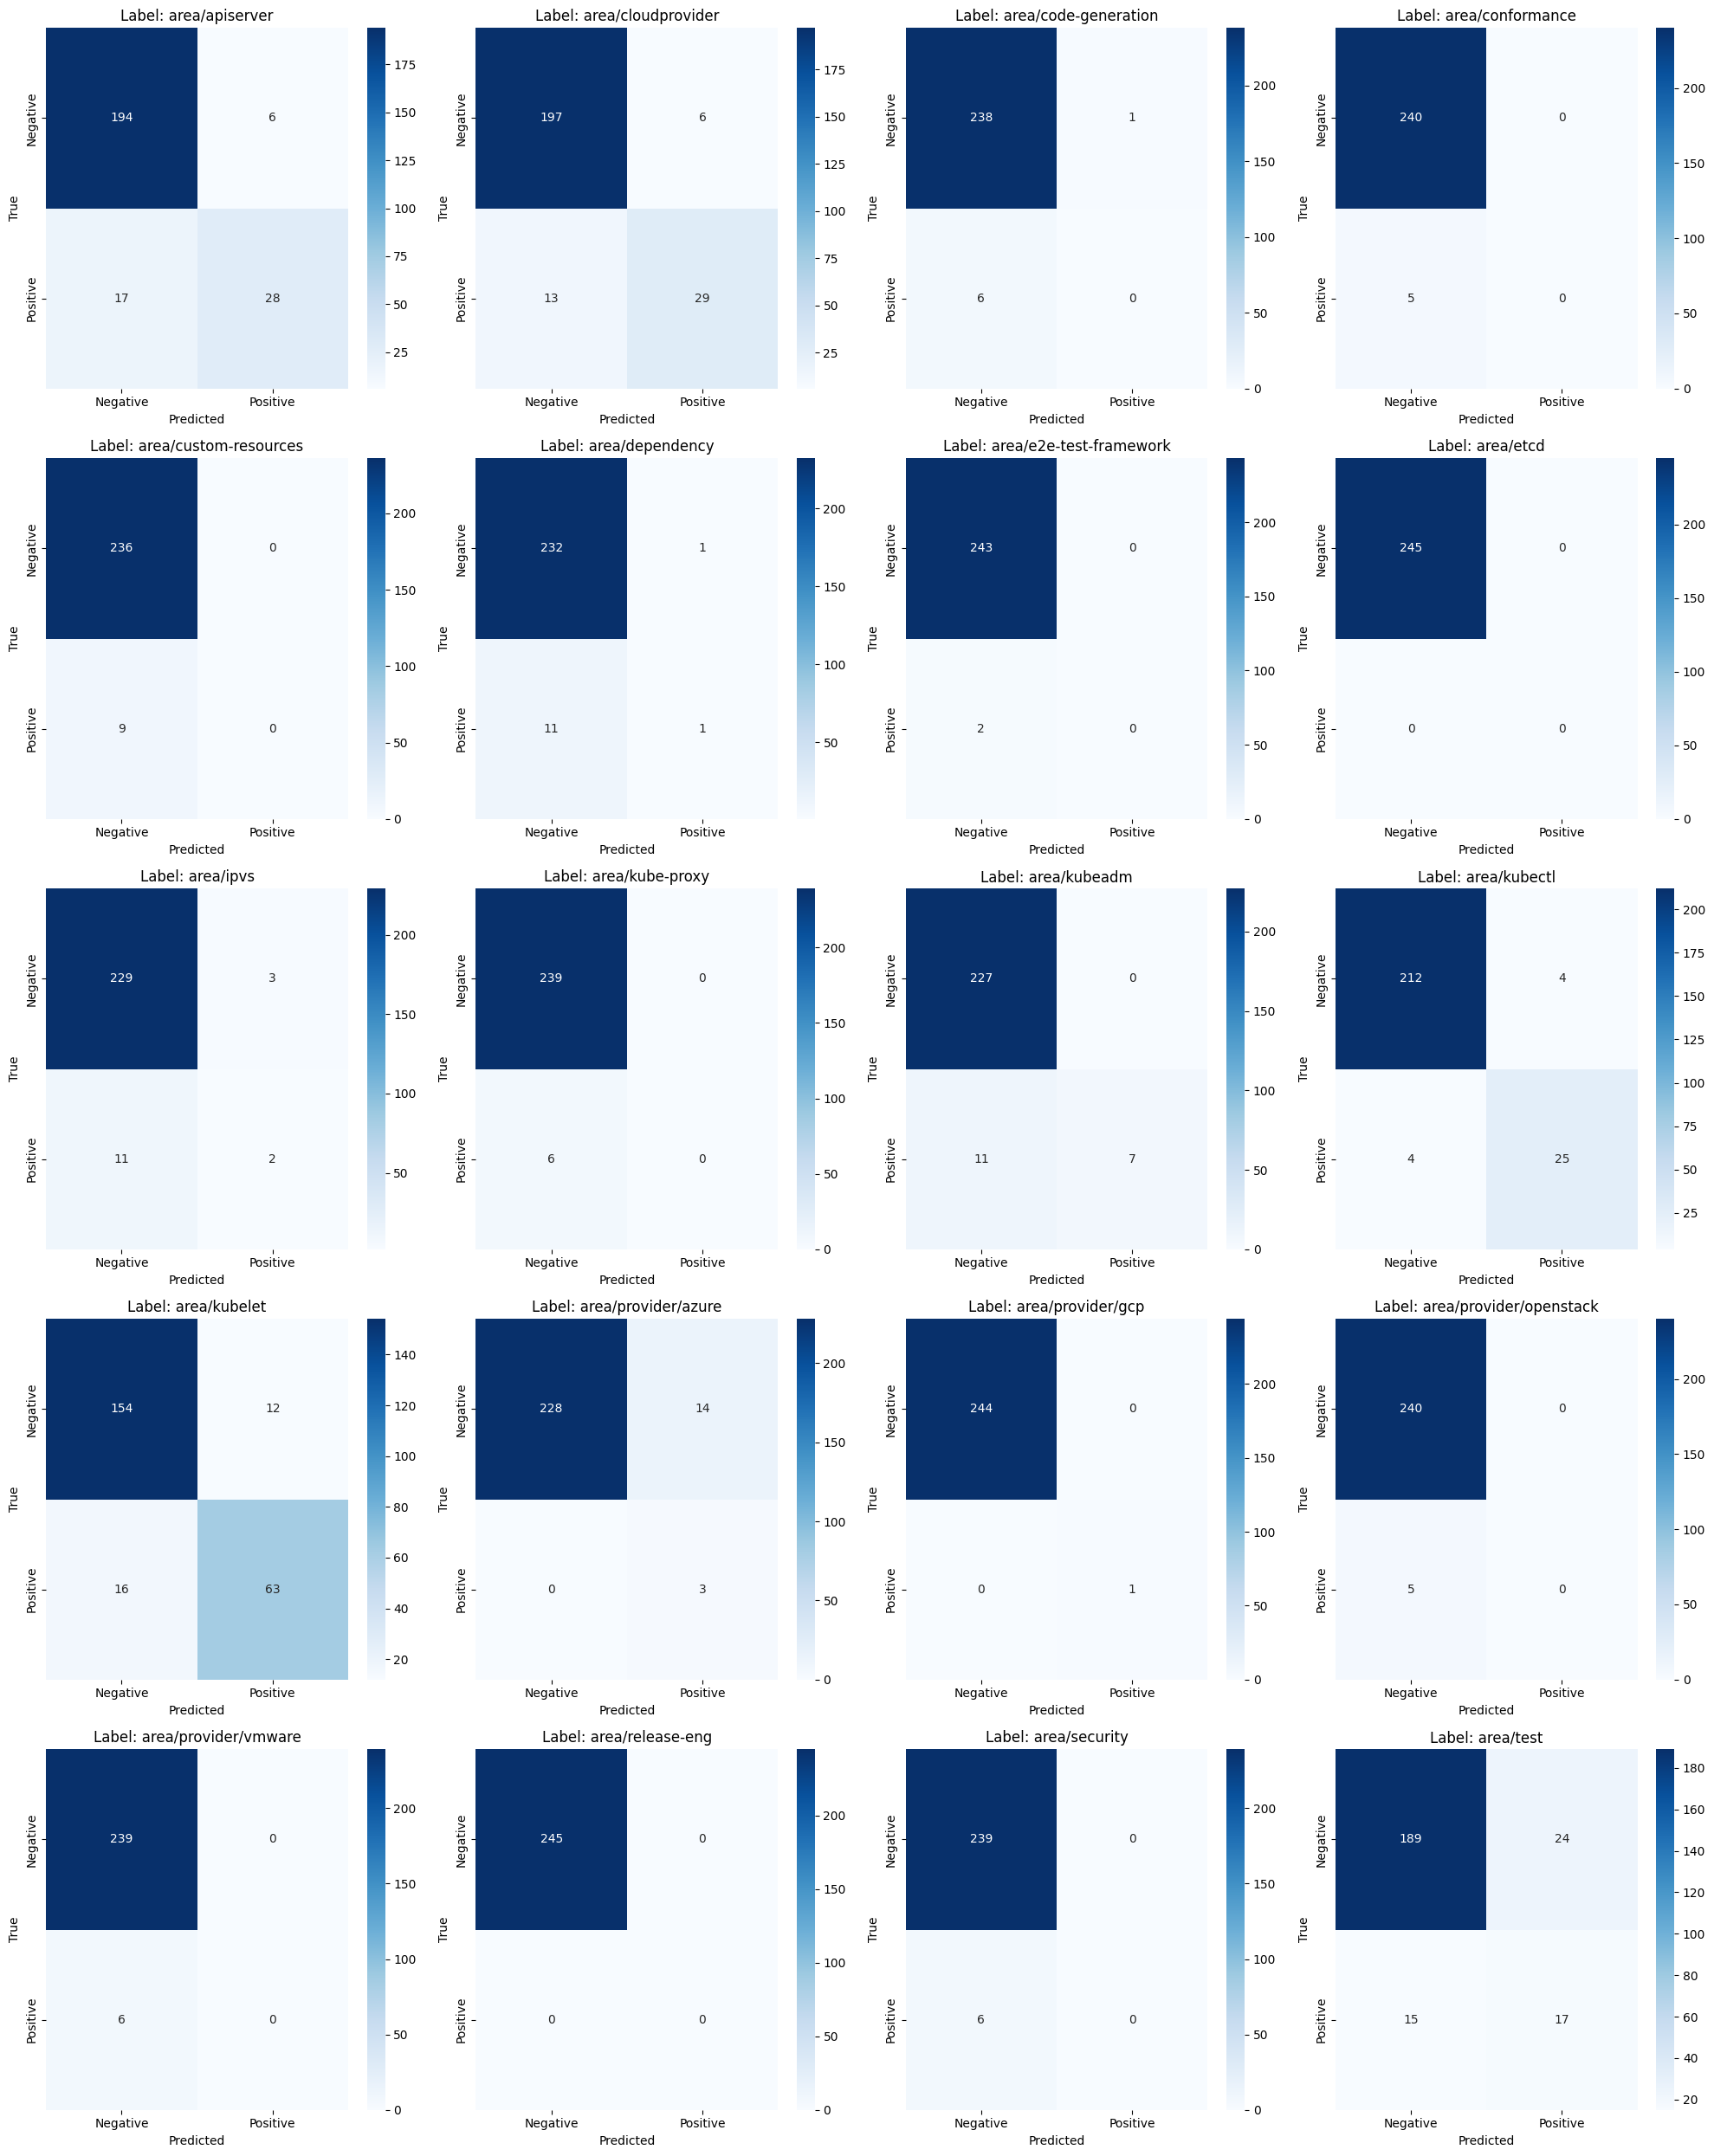

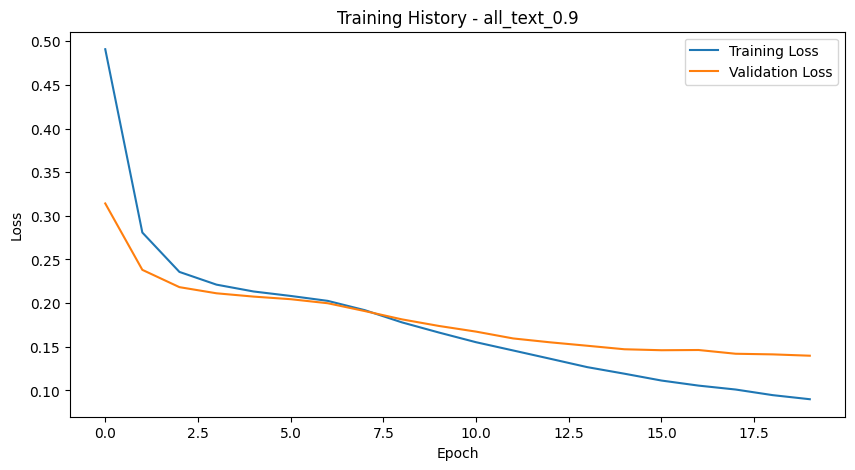

In [15]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/final-kubernetes-bug-data/cleaned_data_with_changed_files.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)